In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
import jax.numpy as jnp
from jax import random, vmap

import numpy as onp

import matplotlib.pyplot as plt
import pickle

In [3]:
from ground_truth import gt_op
from generate_data import generate_lhs_data, import_data
from sequential import objective

import sys
sys.path.append('..') # makes modules in parent repository available to import

from acquisition import MCAcquisition

I0000 00:00:1711046984.451501  127353 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
2024-03-21 14:49:49.126005: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
N_y = 64
dim_u = 4 # grid definition of intput functions
dim_s = N_y**2 # grid definition of output functions
lb = -jnp.ones((dim_u,)) # lower brounds; shape (4,)
ub = jnp.ones((dim_u,)) # upper brounds; shape (4,)
bounds = (lb, ub) # bounds of sampled functions

xx, yy = jnp.meshgrid(jnp.arange(N_y) / N_y, jnp.arange(N_y) / N_y ) # shapes (N_y,N_y) and (N_y,N_y)
y0 = jnp.concatenate([xx[:, :, None], yy[:, :, None]], axis=-1).reshape((-1, 2)) # shape (N_y**2, 2) # values of y; shape (N_y^2, 2)

In [5]:
posterior = lambda x : x

acq_model = MCAcquisition(posterior, (lb, ub),
                        acq_fn = 'random_unif')

In [6]:
acq_model.next_best_point(q=1)

Array([-0.692994  , -0.23709604, -0.4979277 , -0.7958673 ], dtype=float32)

In [22]:
def get_dataset(seed, num_init=15, num_new=85, q=1):
    # initializes training dataset
    num_init = 15 # number of initial examples
    if seed in [0,1,2,3,4]: # import initial data from aziz datesets for fair comparison
        dataset = import_data(num_init, seed)
    else: # create new random dataset
        dataset = generate_lhs_data(num_init, seed)
    u_train, y_train, s_train, w_train = dataset
    for i in range(num_new):
        new_coeffs = acq_model.next_best_point(q=1).reshape(q,-1)
        u_new = new_coeffs # (q, dim_u)
        y_new = jnp.tile(y0, (q, 1, 1)) # (q, dim_s, P)
        s_new = jnp.array([gt_op(u) for u in new_coeffs]) # (q, dim_s, sol_dim)
        w_new = 1/jnp.linalg.norm(s_new, axis=(-1,-2))[:,None]**2 # (q,1)

        # augumenting dataset
        u_train = jnp.concatenate([u_train, u_new], axis=0) # shape (N+q, dim_u)
        y_train = jnp.concatenate([y_train, y_new], axis=0) # shape (N+q, dim_s, P)
        s_train = jnp.concatenate([s_train, s_new], axis=0) # shape (N+q, dim_s)
        w_train = jnp.concatenate([w_train, w_new], axis=0) # shape (N+q, 1)
    return (u_train, y_train, s_train, w_train)

In [23]:
folder_name = 'collected_datasets/'
obj_hist = []
for seed in [0,1,2,3,4]:
    # Collect dataset
    dataset = get_dataset(seed)

    # Save dataset
    file_name = f'dataset_85_random_unif_seed{seed}.npz'
    with open(folder_name+file_name, 'wb') as f:
        pickle.dump(dataset, f)
    
    # Compute objectives
    obj_hist.append(vmap(objective)(dataset[2]))    

In [26]:
[-v.min() for v in obj_hist]

[Array(0.11292326, dtype=float32),
 Array(0.1974566, dtype=float32),
 Array(0.66881204, dtype=float32),
 Array(0.05902921, dtype=float32),
 Array(0.19599706, dtype=float32)]

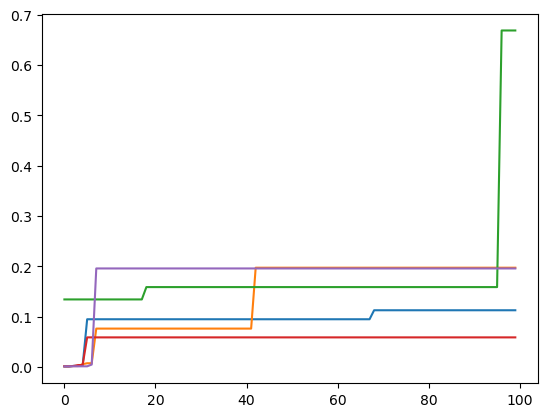

In [27]:
for obj in obj_hist:
    plt.plot(-onp.minimum.accumulate(obj))
plt.show()

In [28]:
regrets = [-onp.minimum.accumulate(obj) for obj in obj_hist]

In [32]:
with open('random_unif_regrets.npz', 'wb') as f:
    pickle.dump(regrets, f)

In [33]:
rs = pickle.load(open('random_unif_regrets.npz', "rb"))

In [34]:
type(rs)

list

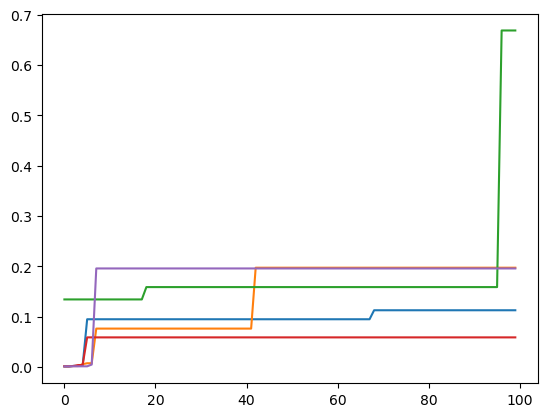

In [36]:
for r in rs:
    plt.plot(r)

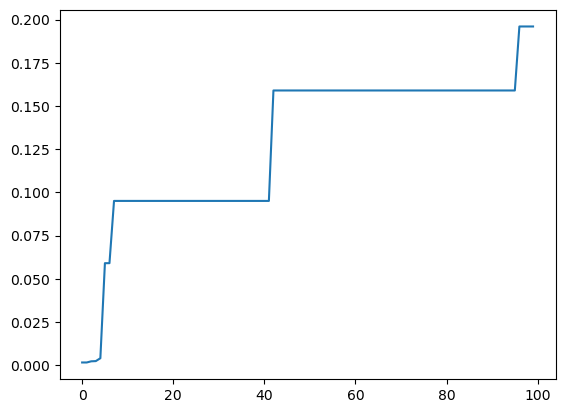

In [41]:
m = onp.median(onp.array(rs), axis=0)
plt.plot(m)